<h2 style="font-weigt:bold;">TUGAS BESAR C MACHINE LEARNING</h2>

- Arjuna Marcelino - 13519021
- Sharon Bernadetha Marbun - 13519092
- Epata Tuah - 13519120
- Giant Andreas Tambunan - 13519127

### Pembacaan Data

In [1]:
import pandas as pd

def read_model():
    f = pd.read_csv("model.csv")
    return f

def read_data():
    df = pd.read_csv('iris.csv')
    # encode species
    df['species'] = df['species'].replace(['setosa'],1)
    df['species'] = df['species'].replace(['versicolor'],2)
    df['species'] = df['species'].replace(['virginica'],3)

    # deviding species colloumn into 3 collumn
    y = pd.get_dummies(df.species, prefix='Class')
    df["Class_1"] = y["Class_1"]
    df["Class_2"] = y["Class_2"]
    df["Class_3"] = y["Class_3"]
    return df

### Fungsi Aktivasi

In [2]:
import math
import numpy as np

def linear(x, kwargs=None):
    return x
    
def sigmoid(x):
    value = float(1 / (1 + math.exp(x * -1)))
    return value

def relu(x, kwargs):
    alpha = kwargs.get("alpha", 0.0)
    max_value = kwargs.get("max_value", None)
    threshold = 0
    if x < threshold:
        return max(x, x * alpha)
    else:
        if max_value == None:
            return x
        else:
            return min(x, max_value)

### Kelas Neuron

In [3]:
class Neuron:
    def __init__(self, value, weight):
        self.value = value
        self.weight = weight    

    def set_value(self, value):
        self.value = value

    def set_weight(self, weight):
        self.weight = weight

    def get_result(self, prev_layer, activation):
        sigma = self.get_sigma(prev_layer=prev_layer)
        result = None
        if activation == "sigmoid":
            result = sigmoid(sigma)

        elif activation == "linier":
            result = linear(sigma)
            
        elif activation == "relu":
            result = relu(sigma)
        
        self.set_value(result)
    
    def get_sigma(self, prev_layer):
        i = 0
        sigma = 0
        for n in prev_layer.neurons:
            sigma += n.value * self.weight[i]
            i += 1
        sigma += prev_layer.bias.value
        
        return sigma

    def get_string_json(self):
        string = "\t\t\t{\n"
        string += f'\t\t\t\t"value" : {self.value},\n'
        w = self.weight
        if self.weight != None:
            w = self.weight 
        else:
            w = "null"
        string += f'\t\t\t\t"weight" : {w}\n'
        string += "\t\t\t}"
        return string

### Kelas Layer

In [4]:
import random

class Layer:
    def __init__(self, idx:int, num_of_neuron:int, activation:str, type:str, prev_layer):
        self.bias = Neuron(random.random(), weight=None)
        self.neurons = []
        self.activation = activation
        self.idx = idx
        self.type = type
        self.prev_layer = prev_layer

        if type == "input":
            for i in range(num_of_neuron):
                n = Neuron(0, weight=None)
                self.neurons.append(n)

        elif type == "hidden":
            num_prev_neuron = len(prev_layer.neurons)
            for i in range(num_of_neuron):
                n = Neuron(0, weight=[random.random() for x in range(num_prev_neuron)])
                self.neurons.append(n)

        elif type == "output":
            self.bias = None
            num_prev_neuron = len(prev_layer.neurons)
            for i in range(num_of_neuron):
                n = Neuron(0, weight=[random.random() for x in range(num_prev_neuron)])
                self.neurons.append(n)


    def set_values(self, values):
        i = 0
        for n in self.neurons:
            n.set_value(values[i])
            i += 1

    def set_neuron_bias(self, biases):
        i = 0
        for n in self.neurons:
            n.bias_weight = biases[i]
            i += 1

    def set_weights(self, weights:list[list[float]]):
        i = 0
        for n in self.neurons:
            n.set_weight(weights[i])
            i += 1

    def get_result(self):
        for n in self.neurons:
            n.get_result(self.prev_layer, self.activation)

    def back_prop(self, detot, learning_rate):
        # check if not input layer
        if self.type == "input":
            return
        
        i = 0
        temp_detot = []
        for n in self.neurons:
            derr_tot = 0
            dout_dnet = n.value * (1 - n.value)
            for err in detot:
                derr_tot += err[i]
            temp = derr_tot * dout_dnet
            temp_neuron = []

            for j in range(len(n.weight)):
                dnet_dw = self.prev_layer.neurons[j].value
                derr_dw = derr_tot * dout_dnet * dnet_dw
                temp_neuron.append(temp * n.weight[j])
                # update weight
                updated = n.weight[j] - (learning_rate * derr_dw)
                n.weight[j] = updated

            temp_detot.append(temp_neuron)
            i += 1
        
        self.prev_layer.back_prop(temp_detot, learning_rate)

    def print_layer(self):
        print(f"Layer {self.idx} ({self.type})")
        print(f"activation func = {self.activation}")
        for n in self.neurons:
            print(f"Neuron weight = {n.weight} \t Neuron value = {n.value}")
        if self.type != "output":
            print(f"Bias = {self.bias.value}")
        print(f"prev layer idx = {self.prev_layer}")
        print("\n")

    def get_string_json(self):
        # attribute
        string = "\t\t{\n"
        string += f'\t\t\t"idx": "{self.idx}",\n'
        string += f'\t\t\t"num_of_neuron": "{len(self.neurons)}",\n'
        string += f'\t\t\t"activation": "{self.activation}",\n'
        string += f'\t\t\t"type": "{self.type}",\n'
        # neuron
        string += f'\t\t\t"neurons": [\n'
        i = 0
        for neu in self.neurons:
            string += neu.get_string_json()
            if i != len(self.neurons)-1:
                string += ','
            i += 1
        string += '],\n'
        bias = self.bias
        if bias == None:
            bias = "null"
        else:
            bias = bias.value
        string += f'\t\t\t"bias": {bias}'
        string += "\t\t}"
        return string

### Kelas FFNN

In [5]:
# FFNN Class
import json
from collections import namedtuple

# customDecoder function for read from json
def customDecoder(dict):
    return namedtuple('X', dict.keys())(*dict.values())

class FeedForwardNeuralNetwork:
    def __init__(self, model, learning_rate, error_threshold, max_iteration, json_filename):
        if json_filename != None:
            # read json file
            file = open(json_filename, 'r')
            ffnn_json = json.load(file, object_hook = customDecoder)

            self.input_layer = Layer(ffnn_json.input_layer.idx,
                                        int(ffnn_json.input_layer.num_of_neuron),
                                        ffnn_json.input_layer.activation,
                                        ffnn_json.input_layer.type,
                                        prev_layer=None)

            self.input_layer.bias.value = float(ffnn_json.input_layer.bias)
            i = 0
            # update weight
            for neu in self.input_layer.neurons:
                neu.value = ffnn_json.input_layer.neurons[i].value
                neu.weight = ffnn_json.input_layer.neurons[i].weight
                i += 1
            
            
            self.hidden_layer = []
            i = 0
            temp = self.input_layer
            for hid in ffnn_json.hidden_layer:
                hid = Layer(ffnn_json.hidden_layer[i].idx,
                            int(ffnn_json.hidden_layer[i].num_of_neuron),
                            ffnn_json.hidden_layer[i].activation,
                            ffnn_json.hidden_layer[i].type,
                            prev_layer= temp)
                j = 0
                # update weight
                for neu in hid.neurons:
                    neu.value = float(ffnn_json.hidden_layer[i].neurons[j].value)
                    neu.weight = ffnn_json.hidden_layer[i].neurons[j].weight
                    j += 1
                
                hid.bias.value = float(ffnn_json.hidden_layer[i].bias)
                self.hidden_layer.append(hid)
                temp = hid
                i += 1

            self.output_layer = Layer(ffnn_json.output_layer.idx,
                                        int(ffnn_json.output_layer.num_of_neuron),
                                        ffnn_json.output_layer.activation,
                                        ffnn_json.output_layer.type,
                                        prev_layer=temp)
            # update weight
            i = 0
            for neu in self.output_layer.neurons:
                neu.value = float(ffnn_json.output_layer.neurons[i].value)
                neu.weight = ffnn_json.output_layer.neurons[i].weight
                i += 1
            
            self.output_layer.bias = ffnn_json.output_layer.bias
            self.learning_rate = float(ffnn_json.learning_rate)
            self.error_threshold = float(ffnn_json.error_threshold)
            self.max_itteration = int(ffnn_json.max_iteration)
            return
        
        self.input_layer = None
        self.hidden_layer = []
        self.output_layer = None
        self.learning_rate = learning_rate
        self.error_threshold = error_threshold
        self.max_itteration = max_iteration

        temp_layer = None
        for index, items in model.iterrows():
            if index == 0:
                self.input_layer = Layer(index, items["neuron"], items["activation"], "input", prev_layer=None)
                temp_layer = self.input_layer
            elif index > 0 and index < model.index.stop - 1:
                layer = Layer(index, items["neuron"], items["activation"], "hidden", prev_layer=temp_layer)
                temp_layer = layer
                self.hidden_layer.append(layer)
            elif index == model.index.stop-1:
                self.output_layer = Layer(index, items["neuron"], items["activation"], "output", prev_layer=temp_layer)

    def forward_propagation(self, input):
        # assume len input = len input_layer.neurons
        self.input_layer.set_values(input)
        for lay in self.hidden_layer:
            lay.get_result()
        self.output_layer.get_result()
        
    def backward_propagation(self, target):
        i = 0
        temp_detot = []
        # update output layer weights
        for out_n in self.output_layer.neurons:
            derr_dout = out_n.value - target[i]
            dout_dy = out_n.value * (1- out_n.value)
            temp = derr_dout * dout_dy
            temp_neuron = []
            
            for j in range(len(out_n.weight)):
                dy_dw = self.output_layer.prev_layer.neurons[j].value
                derr_dw = derr_dout * dout_dy * dy_dw
                temp_neuron.append(temp * out_n.weight[j]) # for hidden layer
                # update
                updated = out_n.weight[j] - (self.learning_rate * derr_dw)
                out_n.weight[j] = updated
            
            temp_detot.append(temp_neuron)
            i += 1
        
        # backprop and update for hidden layer
        self.output_layer.prev_layer.back_prop(temp_detot, self.learning_rate)
        
    
    def learn(self, data_train):
        # fromat data_train harus sesuai dengan data yang diambil dari read_data()  
        # iterate for each data
        for idx, data in data_train.iterrows():
            input = []
            # input
            for i in range(len(self.input_layer.neurons)):
                input.append(data[i])
            
            # output
            target = [data["Class_1"], data["Class_2"], data["Class_3"]]

            # set input layer
            self.input_layer.set_values(input)
            # forward and backward propagation
            self.forward_propagation(input)
            self.backward_propagation(target)
            # print(f"COST = {self.get_error_cost(target)}")
        

    def get_error_cost(self, target):
        cost = 0
        i = 0
        for n in self.output_layer.neurons:
            dif = target[i] - n.value
            cost += (dif ** 2)/2
            i += 1
        return cost

    def predict(self, test_data):
        result = []
        num_true = 0
        for idx, data in test_data.iterrows():
            input = []
            # input
            for i in range(len(self.input_layer.neurons)):
                input.append(data[i])
            # output
            target = [data["Class_1"], data["Class_2"], data["Class_3"]]

            # set input layer
            self.input_layer.set_values(input)
            # forward propagation
            self.forward_propagation(input)
            temp = -1
            idx = 0
            i = 1
            for out_n in self.output_layer.neurons:
                if temp < out_n.value:
                    temp = out_n.value
                    idx = i
                i += 1
            temp_result = []
            if idx == 1:
                temp_result = [1, 0, 0]
            elif idx == 2:
                temp_result = [0, 1, 0]
            elif idx == 3:
                temp_result = [0, 0, 1]
            
            result.append(temp_result)
            # predict
            if target == temp_result:
                num_true += 1
        return result, num_true/len(result)
    
    def predict_instance(self, instance):
        # predicting one instance
        # instance : list input (ex: [1.2, 2.3, 3,4, 4.5])
        # output: class (ex: [0,0,1])
        self.forward_propagation(instance)

        temp = -1
        idx = 0
        i = 1
        for out_n in self.output_layer.neurons:
            if temp < out_n.value:
                temp = out_n.value
                idx = i
            i += 1
        result = []
        cls = 0
        if idx == 1:
            result = [1, 0, 0]
            cls = 0
        elif idx == 2:
            result = [0, 1, 0]
            cls = 1
        elif idx == 3:
            result = [0, 0, 1]
            cls = 2
        
        return result, cls

    def print_neural_network(self):
        self.input_layer.print_layer()
        for lay in self.hidden_layer:
            lay.print_layer()
        self.output_layer.print_layer()

    def get_str_json(self):
        # __init__(self, model, learning_rate, error_threshold, max_iteration):
        string = "{\n"
        string += f'\t"learning_rate": "{self.learning_rate}",\n'
        string += f'\t"error_threshold": "{self.error_threshold}",\n'
        string += f'\t"max_iteration": "{self.max_itteration}",\n'
        string += f'\t"input_layer": {self.input_layer.get_string_json()},\n'
        string += f'\t"hidden_layer": [\n'
        for lay in self.hidden_layer:
            string += lay.get_string_json()
        string += '],\n'
        string += f'\t"output_layer": {self.output_layer.get_string_json()}\n'
        string += "}"
        return string

    def save_to_json(self, file_name):
        jsonFile = open(file_name, "w")
        jsonFile.write(self.get_str_json())
        jsonFile.close()


### Utilitas

In [6]:
def convert_class(result):
    new = []
    for i in range(len(result)):
        if result[i] == [1, 0, 0]:
            new.append(0)
        elif result[i] == [0, 1, 0]:
            new.append(1)
        else:  # result[i] == [0,0,1]
            new.append(2)
    return new

def conf_matrix(actual, predicted):
    actual0_predicted0 = 0
    actual0_predicted1 = 0
    actual0_predicted2 = 0
    actual1_predicted0 = 0
    actual1_predicted1 = 0
    actual1_predicted2 = 0
    actual2_predicted0 = 0
    actual2_predicted1 = 0
    actual2_predicted2 = 0
    num_data = len(actual)
    for i in range(num_data):
        if actual[i] == 0 and predicted[i] == 0:
            actual0_predicted0 += 1
        elif actual[i] == 0 and predicted[i] == 1:
            actual0_predicted1 += 1
        elif actual[i] == 0 and predicted[i] == 2:
            actual0_predicted2 += 1
        elif actual[i] == 1 and predicted[i] == 0:
            actual1_predicted0 += 1
        elif actual[i] == 1 and predicted[i] == 1:
            actual1_predicted1 += 1
        elif actual[i] == 1 and predicted[i] == 2:
            actual1_predicted2 += 1
        elif actual[i] == 2 and predicted[i] == 0:
            actual2_predicted0 += 1
        elif actual[i] == 2 and predicted[i] == 1:
            actual2_predicted1 += 1
        else:  # actual[i] == 2 and predicted[i] == 2:
            actual2_predicted2 += 1
    row0 = [actual0_predicted0, actual0_predicted1, actual0_predicted2]
    row1 = [actual1_predicted0, actual1_predicted1, actual1_predicted2]
    row2 = [actual2_predicted0, actual2_predicted1, actual2_predicted2]
    return [row0, row1, row2]

def performance_measure(conf_matrix):
    tp_se = conf_matrix[0][0]
    fn_se = conf_matrix[0][1] + conf_matrix[0][2]
    fp_se = conf_matrix[1][0] + conf_matrix[2][0]
    tn_se = conf_matrix[1][1] + conf_matrix[1][2] + conf_matrix[2][1] + conf_matrix[2][2]

    tp_ve = conf_matrix[1][1]
    fn_ve = conf_matrix[1][0] + conf_matrix[1][2]
    fp_ve = conf_matrix[0][1] + conf_matrix[2][1]
    tn_ve = conf_matrix[0][0] + conf_matrix[0][2] + conf_matrix[2][0] + conf_matrix[2][2]

    tp_vi = conf_matrix[2][2]
    fn_vi = conf_matrix[2][0] + conf_matrix[2][1]
    fp_vi = conf_matrix[0][2] + conf_matrix[1][2]
    tn_vi = conf_matrix[0][0] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[1][1]

    pos_se = tp_se+fn_se
    neg_se = fp_se+tn_se

    pos_aks_se = tp_se+fp_se

    pos_ve = tp_ve+fn_ve
    neg_ve = fp_ve+tn_ve

    pos_aks_ve = tp_ve+fp_ve

    pos_vi = tp_vi+fn_vi
    neg_vi = fp_vi+tn_vi

    pos_aks_vi = tp_vi+fp_vi

    Num = pos_se+neg_se

    akurasi = [(tp_se+tn_se)/Num, (tp_ve+tn_ve)/Num, (tp_vi+tn_vi)/Num ]
    presisi = [tp_se/pos_aks_se if pos_aks_se != 0 else 0,tp_ve/pos_aks_ve if pos_aks_ve != 0 else 0,tp_vi/pos_aks_vi if pos_aks_vi != 0 else 0]
    recall = [tp_se/pos_se if pos_se != 0 else 0,tp_ve/pos_ve if pos_ve != 0 else 0,tp_vi/pos_vi if pos_vi != 0 else 0]
    f1 = [2*(presisi[0]*recall[0])/(presisi[0]+recall[0]) if presisi[0]+recall[0] != 0 else 0,2*(presisi[1]*recall[1])/(presisi[1]+recall[1]) if presisi[1]+recall[1] != 0 else 0,2*(presisi[2]*recall[2])/(presisi[2]+recall[2])if presisi[2]+recall[2] != 0 else 0]

    return akurasi, presisi, recall, f1

def get_class(num):
    match num:
        case 0:
            return 'Setosa'
        case 1:
            return 'Versicolor'
        case 2:
            return 'Virginica'


### Eksekusi 

#### Pembelajaran dengan FFNN

In [7]:
model = read_model()
neural_network = FeedForwardNeuralNetwork(model=model, learning_rate=0.2, error_threshold=0.01, max_iteration=1000, json_filename=None)

data = read_data()

for i in range(1000):
    neural_network.learn(data)

result, acc = neural_network.predict(test_data=data)
predicted = convert_class(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in data.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_class(target)
print(f"\nactual = {actual}")

print(f"\nAccuracy score = {acc}")


predicted = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

actual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Accuracy score = 0.9666666666666667


<b> Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1 </b>

[[50, 0, 0], [0, 45, 5], [0, 0, 50]]


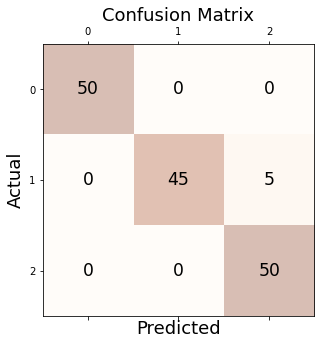

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  0.9666666666666667
Presisi = 1.0
Recall = 0.9
F1 =  0.9473684210526316

Kelas Virginica
Akurasi =  0.9666666666666667
Presisi = 0.9090909090909091
Recall = 1.0
F1 =  0.9523809523809523


In [8]:
import matplotlib.pyplot as plt

conf_mat = conf_matrix(actual, predicted)
print(conf_mat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(3):
    for j in range(3):
        ax.text(x=j, y=i, s=conf_mat[i][j], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()



pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])

#### Pembelajaran dengan SKlearn

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

iris = load_iris()
X = iris.data
y = iris.target

mlpclassifier = MLPClassifier(  hidden_layer_sizes=1,
                                learning_rate="constant",
                                activation="logistic",
                                solver="sgd",
                                batch_size=2,
                                learning_rate_init=0.1,
                                tol=0.1,
                                max_iter=200)

mlpclassifier.fit(X, y)

pred = mlpclassifier.predict(X)
print(f"predicted = {pred.tolist()}")

print(f"\nactual = {y.tolist()}")

print(f'\nAccuracy score = {accuracy_score(pred, y)}')

predicted = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

actual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Accuracy score = 0.3333333333333333


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

Confusion matrix: [[0, 0, 0], [50, 50, 50], [0, 0, 0]]

Kelas Setosa
Akurasi =  0.6666666666666666
Presisi = 0.0
Recall = 0
F1 =  0

Kelas Versicolor
Akurasi =  0.3333333333333333
Presisi = 1.0
Recall = 0.3333333333333333
F1 =  0.5

Kelas Virginica
Akurasi =  0.6666666666666666
Presisi = 0.0
Recall = 0
F1 =  0


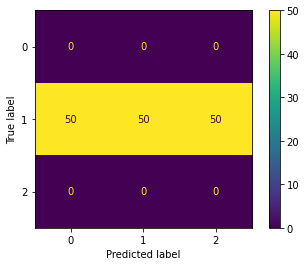

In [10]:
import numpy as np
cm = confusion_matrix(pred, y)

cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
print(f"Confusion matrix: {cm.tolist()}")
pm = performance_measure(cm.tolist())

print("\nKelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])


-------

##### Analisis Perbandingan Pembelajaran dengan SKlearn

Dari hasil pembelajaran batch, diperoleh total akurasi sebesar 96.67% dengan confusion matriks = [[50, 0, 0], [0, 45, 5], [0, 0, 50]].
Perhitungan kinerja secara lebih detail berdasarkan kelas adalah sebagai berikut. 

- Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

- Kelas Versicolor
Akurasi =  0.9666666666666667
Presisi = 1.0
Recall = 0.9
F1 =  0.9473684210526316

- Kelas Virginica
Akurasi =  0.9666666666666667
Presisi = 0.9090909090909091
Recall = 1.0
F1 =  0.9523809523809523

Sedangkan dari pembelajaran SKlearn memanfaatkan MLPClassifier, diperoleh akurasi yang lebih rendah yaitu sebesar 33.33% dengan confusion matrix = [[0, 0, 0], [50, 50, 50], [0, 0, 0]].
Perhitungan kinerja secara lebih detail berdasarkan kelas adalah sebagai berikut. 
- Kelas Setosa
Akurasi =  0.6666666666666666
Presisi = 0.0
Recall = 0
F1 =  0

- Kelas Versicolor
Akurasi =  0.3333333333333333
Presisi = 1.0
Recall = 0.3333333333333333
F1 =  0.5

- Kelas Virginica
Akurasi =  0.6666666666666666
Presisi = 0.0
Recall = 0
F1 =  0


----

#### Pembelajaran dengan skema 90% training dan 10% test

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

train = data.sample(frac=0.9)
test = data.loc[~data.index.isin(train.index)]

for i in range(1000):
    neural_network.learn(train)
    
result, acc = neural_network.predict(test_data=test)
predicted = convert_class(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in test.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_class(target)
print(f"actual = {actual}")

print(f"Accuracy score = {acc}")

predicted = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2]
actual = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2]
Accuracy score = 1.0


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

[[7, 0, 0], [0, 3, 0], [0, 0, 5]]


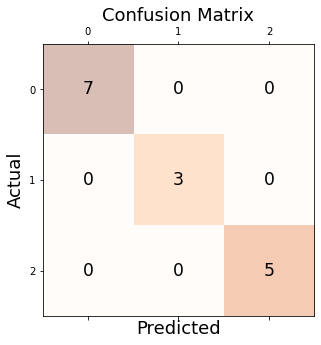

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Virginica
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0


In [12]:
conf_mat = conf_matrix(actual, predicted)
print(conf_mat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(3):
    for j in range(3):
        ax.text(x=j, y=i, s=conf_mat[i][j], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])

----

##### Analisis pembelajaran dengan skema 90% training dan 10% test

Pada pembelajaran FFNN untuk dataset iris dengan skema split train 90% dan test 10%, didapatkan confusion matrix hanya akan memiliki nilai pada sel yang bernilai true positif untuk setiap kelas dan sisanya akan bernilai 0. Hal ini berakibat pada pengukuran performansi yang didapatkan menghasilkan akurasi pembelajaran 100%, presisi pembelajaran 100%, recall pembelajaran 100%, dan F1 pembelajaran 100%. Artinya, dengan pembelajaran ini, data yang diprediksi memiliki hasil yang sama dengan aktual atau ekspektasi datanya.

----

#### Pembelajaran dengan skema 10-fold cross validation

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state=0)
result = next(kf.split(data), None)
train = data.iloc[result[0]]
test =  data.iloc[result[1]]

for i in range(1000):
    neural_network.learn(train)
    
result, acc = neural_network.predict(test_data=test)
predicted = convert_class(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in test.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_class(target)
print(f"actual = {actual}")

print(f"Accuracy score = {acc}")

predicted = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
actual = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
Accuracy score = 1.0


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

[[3, 0, 0], [0, 8, 0], [0, 0, 4]]


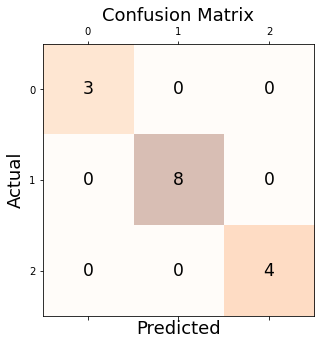

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Virginica
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0


In [14]:
conf_mat = conf_matrix(actual, predicted)
print(conf_mat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(3):
    for j in range(3):
        ax.text(x=j, y=i, s=conf_mat[i][j], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])

### Save Model to External File

In [15]:
neural_network.save_to_json("weighted_model.json")

### Load Model and Predict New Instance 

Misalkan instance baru yang hendak dicek adalah instance yang memiliki sepal_length 6.9, sepal_width 3.3, petal_length 4.2, dan petal_width 1.5.

In [16]:
test_neural_net = FeedForwardNeuralNetwork(model=None, learning_rate=None, error_threshold=None, max_iteration=None ,json_filename="weighted_model.json")

instance = [6.9,3.3,4.2,1.5]
ins_result, ins_class = test_neural_net.predict_instance(instance)
print(f"Class = {get_class(ins_class)}")


Class = Versicolor
